In [1]:
import findspark
findspark.init('/home/ubuntu/spark-3.2.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('722I4').getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/10/10 22:47:52 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## 02-DU 

In [2]:
from pyspark.sql import DataFrame

In [3]:
# Load Dataset
df1 = spark.read.csv('guns_2006.csv', header=True, inferSchema=True)

In [4]:
from pyspark.sql import functions as F
from pyspark.sql.functions import sum, when

# Calculate count of 'NA' for each feature
na_counts = df1.agg(*[(sum(when(F.col(column) == "NA", 1).otherwise(0))).alias(column) for column in df1.columns])

na_counts.show()

+----+-----+------+------+---+---+----+--------+-----+---------+
|year|month|intent|police|sex|age|race|hispanic|place|education|
+----+-----+------+------+---+---+----+--------+-----+---------+
|   0|    0|     0|     0|  0|  9|   0|       0|  358|     1615|
+----+-----+------+------+---+---+----+--------+-----+---------+



## 03-DP

In [5]:
distinct_races = df1.select("race").distinct().rdd.flatMap(lambda x: x).collect()
print(set(distinct_races))

{'White', 'Asian/Pacific Islander', 'Black', 'Hispanic', 'Native American/Native Alaskan'}


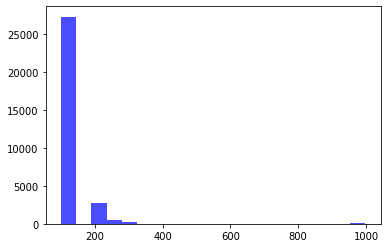

In [6]:
import matplotlib.pyplot as plt

hispanic_data = df1.select("hispanic").rdd.flatMap(lambda x: x).collect()
plt.hist(hispanic_data, bins=20, color='blue', alpha=0.7)
plt.show()

In [7]:
# Delete 'hispanic' column
df1 = df1.drop('hispanic')

In [8]:
from pyspark.sql.functions import col

In [9]:
# Convert 'NA' to null
for column in df1.columns:
    df1 = df1.withColumn(column, when(F.col(column) == "NA", None).otherwise(F.col(column)))

# Drop null values
df1 = df1.dropna()

In [10]:
from pyspark.sql.types import IntegerType

# Delete outliers

df1 = df1.withColumn("age", df1["age"].cast(IntegerType()))

Q1 = df1.approxQuantile("age", [0.25], 0)[0]
Q3 = df1.approxQuantile("age", [0.75], 0)[0]
IQR = Q3 - Q1

lower_threshold = Q1 - 1.5 * IQR
upper_threshold = Q3 + 1.5 * IQR

df1 = df1.filter((df1.age >= lower_threshold) & (df1.age <= upper_threshold))

In [11]:
# Drop 'Undetermined' & 'Accidental' values
df1 = df1.filter((df1.intent != 'Undetermined') & (df1.intent != 'Accidental'))

In [12]:
# Repeat the Data Cleaning in each dataset

def preprocess_data(filename):
    df = spark.read.csv(filename, header=True, inferSchema=True)
    
    df = df.drop('hispanic')
    
    for column in df.columns:
        df = df.withColumn(column, when(F.col(column) == "NA", None).otherwise(F.col(column)))

    df = df.dropna()
    
    # 将 'age' 列转换为整数类型
    df = df.withColumn("age", df["age"].cast(IntegerType()))

    # 然后再进行分位数计算和异常值过滤
    Q1 = df.approxQuantile("age", [0.25], 0)[0]
    Q3 = df.approxQuantile("age", [0.75], 0)[0]
    IQR = Q3 - Q1

    lower_threshold = Q1 - 1.5 * IQR
    upper_threshold = Q3 + 1.5 * IQR

    df = df.filter((df.age >= lower_threshold) & (df.age <= upper_threshold))
    
    df = df.filter((df.intent != 'Undetermined') & (df.intent != 'Accidental'))
    
    return df

dataframes = [df1]

for i in range(2007, 2021):
    dataframes.append(preprocess_data(f'guns_{i}.csv'))

In [13]:
from functools import reduce
from pyspark.sql.functions import concat, lit

In [14]:
# Merge 15 datasets
merged_df = reduce(lambda x, y: x.union(y), dataframes)
merged_df = merged_df.drop('police')

## 04-DT 

In [15]:
# Group features
merged_df = merged_df.withColumn(
    "education",
    when(F.col("education").isin(["BA+", "Some college"]), "High")
    .when(F.col("education").isin(["HS/GED", "Less than HS"]), "Low")
    .otherwise(F.col("education"))
)

merged_df = merged_df.withColumn(
    "race",
    when(F.col("race") != "White", "POC")
    .otherwise(F.col("race"))
)

merged_df = merged_df.withColumn(
    "place",
    when(F.col("place") != "Home", "Other")
    .otherwise(F.col("place"))
)

In [16]:
# Create age bins
age_max = merged_df.agg({"age": "max"}).collect()[0][0]
age_min = merged_df.agg({"age": "min"}).collect()[0][0]
bin_width = (age_max - age_min) / 3

merged_df = merged_df.withColumn(
    "age_bins",
    when(F.col("age") <= (age_min + bin_width), "youth")
    .when((F.col("age") > (age_min + bin_width)) & (F.col("age") <= (age_min + 2 * bin_width)), "middle-aged")
    .otherwise("elderly")
)

merged_df = merged_df.drop('age')

## 07-DM 

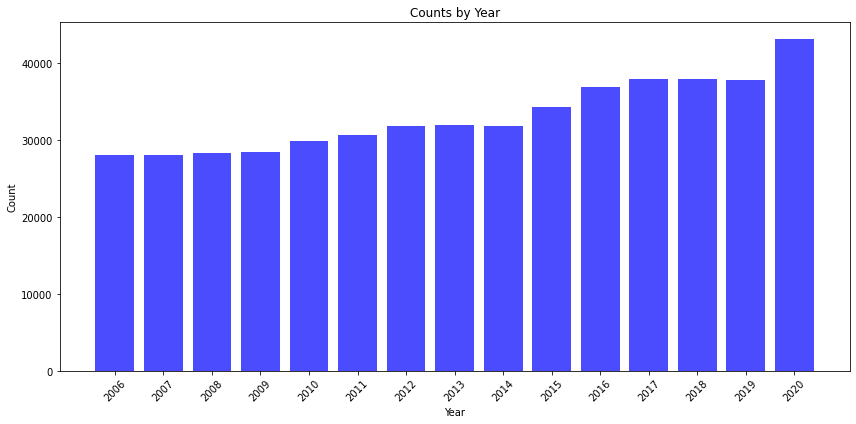

In [17]:
# Group by 'year' column and count
year_counts = merged_df.groupBy('year').count().orderBy('year').collect()
years = [row['year'] for row in year_counts]
year_values = [row['count'] for row in year_counts]

# Plot a bar chart for 'year'
plt.figure(figsize=(12, 6))
plt.bar(years, year_values, color='blue', alpha=0.7)
plt.title('Counts by Year')
plt.xlabel('Year')
plt.ylabel('Count')
plt.xticks(years, rotation=45)
plt.tight_layout()
plt.show()

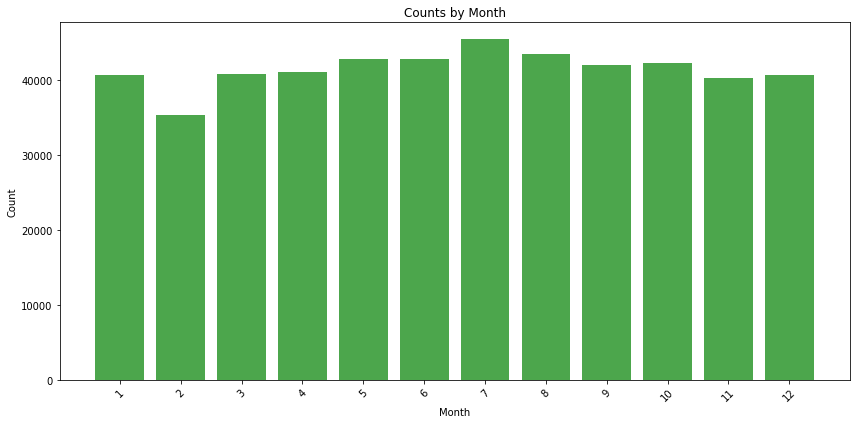

In [18]:
# Group by 'month' column and count
month_counts = merged_df.groupBy('month').count().orderBy('month').collect()
months = [row['month'] for row in month_counts]
month_values = [row['count'] for row in month_counts]

# Plot a bar chart for 'month'
plt.figure(figsize=(12, 6))
plt.bar(months, month_values, color='green', alpha=0.7)
plt.title('Counts by Month')
plt.xlabel('Month')
plt.ylabel('Count')
plt.xticks(months, rotation=45)
plt.tight_layout()
plt.show()

In [19]:
# Clustering for suicide victims
condition = (merged_df['intent'] == 'Suicide')
df_cluster1 = merged_df.filter(condition)

df_cluster1 = df_cluster1.drop('year', 'month', 'intent')

In [20]:
# Transfer the data types of all features to integer

from pyspark.ml.feature import StringIndexer

indexers = {}

columns_to_encode = ["sex", "race", "place", "education", "age_bins"]
mappings = {}

for col in columns_to_encode:
    indexer = StringIndexer(inputCol=col, outputCol=col + "_encoded")
    model = indexer.fit(df_cluster1)
    df_cluster1 = model.transform(df_cluster1)
    indexers[col] = model
    mappings[col] = {index: label for index, label in enumerate(model.labels)}
    df_cluster1 = df_cluster1.drop(col).withColumnRenamed(col + "_encoded", col)

print("Mappings for sex:", mappings['sex'])
print("Mappings for race:", mappings['race'])
print("Mappings for place:", mappings['place'])
print("Mappings for education:", mappings['education'])
print("Mappings for age_bins:", mappings['age_bins'])

Mappings for sex: {0: 'M', 1: 'F'}
Mappings for race: {0: 'White', 1: 'POC'}
Mappings for place: {0: 'Home', 1: 'Other'}
Mappings for education: {0: 'Low', 1: 'High'}
Mappings for age_bins: {0: 'middle-aged', 1: 'youth', 2: 'elderly'}


In [21]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import mean, count
from pyspark.ml.evaluation import ClusteringEvaluator

In [22]:
# Combine all feature columns into a single feature vector
vec_assembler = VectorAssembler(inputCols=df_cluster1.columns, outputCol="features")
df_vec = vec_assembler.transform(df_cluster1)

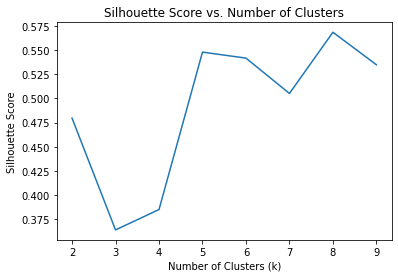

In [23]:
# Determine the optimal k value by Silhouette Score
k_range = range(2, 10)
scores = []

for k in k_range:
    kmeans = KMeans().setK(k).setSeed(0)
    model = kmeans.fit(df_vec)
    transformed_k = model.transform(df_vec)
    evaluator = ClusteringEvaluator()
    silhouette = evaluator.evaluate(transformed_k)
    scores.append(silhouette)

plt.plot(k_range, scores)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. Number of Clusters')
plt.show()

In [34]:
# Conduct K-Means Clustering
num_clusters = 8
kmeans = KMeans().setK(num_clusters).setSeed(0).setInitMode("k-means||")
model = kmeans.fit(df_vec)
transformed = model.transform(df_vec)

In [35]:
from pyspark.sql.functions import col

# Calculate the feature distributions of each cluster
cluster_summary = transformed.groupBy("prediction").agg(
    mean(1 - col("sex")).alias("Male"),
    mean(1 - col("race")).alias("White"),
    mean(1 - col("place")).alias("At Home"),
    mean(1 - col("education")).alias("Low Edu"),
    mean(when(col("age_bins") == 0, 1).otherwise(0)).alias("Middle-aged"),
    count("*").alias("Data Count")
)

cluster_summary = cluster_summary.withColumnRenamed("prediction", "Cluster")

cluster_summary.show()

+-------+------------------+------------------+------------------+------------------+------------------+----------+
|Cluster|              Male|             White|           At Home|           Low Edu|       Middle-aged|Data Count|
+-------+------------------+------------------+------------------+------------------+------------------+----------+
|      1|0.9377074727550248|               1.0|               1.0|0.8866544984896517|0.8283860087312007|     93687|
|      3|0.7158306348139549|0.3819881468809189|               1.0|0.5082788537911651|               0.0|     16367|
|      4|0.7434671136968741|               0.0|0.5238635243072676|0.7702396213391184|               1.0|     20282|
|      2|0.5513744594124372|0.2725058408311378|               0.0|0.5823432917433017|               0.0|     20117|
|      0|  0.87880496054115|               1.0|               0.0|0.8779081684944142|0.7804653069591063|     39028|
+-------+------------------+------------------+------------------+------

In [26]:
# Calculate Silhouette Score
evaluator = ClusteringEvaluator(featuresCol="features")
silhouette = evaluator.evaluate(transformed)
print("Silhouette Score:", silhouette)

Silhouette Score: 0.5682082524015103


In [27]:
# Clustering for homicide victims
condition = (merged_df['intent'] == 'Homicide')
df_cluster2 = merged_df.filter(condition)

df_cluster2 = df_cluster2.drop('year', 'month', 'intent')

In [28]:
indexers = {}

columns_to_encode = ["sex", "race", "place", "education", "age_bins"]
mappings = {}

for col in columns_to_encode:
    indexer = StringIndexer(inputCol=col, outputCol=col + "_encoded")
    model = indexer.fit(df_cluster2)
    df_cluster2 = model.transform(df_cluster2)
    indexers[col] = model
    mappings[col] = {index: label for index, label in enumerate(model.labels)}
    df_cluster2 = df_cluster2.drop(col).withColumnRenamed(col + "_encoded", col)

print("Mappings for sex:", mappings['sex'])
print("Mappings for race:", mappings['race'])
print("Mappings for place:", mappings['place'])
print("Mappings for education:", mappings['education'])
print("Mappings for age_bins:", mappings['age_bins'])

Mappings for sex: {0: 'M', 1: 'F'}
Mappings for race: {0: 'POC', 1: 'White'}
Mappings for place: {0: 'Other', 1: 'Home'}
Mappings for education: {0: 'Low', 1: 'High'}
Mappings for age_bins: {0: 'youth', 1: 'middle-aged', 2: 'elderly'}


In [29]:
vec_assembler = VectorAssembler(inputCols=df_cluster2.columns, outputCol="features")
df_vec = vec_assembler.transform(df_cluster2)

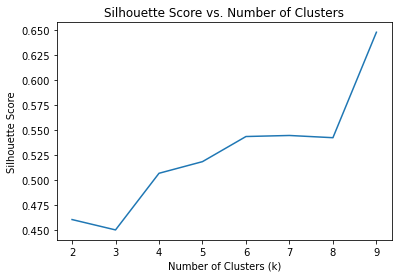

In [30]:
# Determine the optimal k value by Silhouette Score
k_range = range(2, 10)
scores = []

for k in k_range:
    kmeans = KMeans().setK(k).setSeed(0)
    model = kmeans.fit(df_vec)
    transformed_k = model.transform(df_vec)
    evaluator = ClusteringEvaluator()
    silhouette = evaluator.evaluate(transformed_k)
    scores.append(silhouette)

plt.plot(k_range, scores)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. Number of Clusters')
plt.show()

In [36]:
# Conduct K-Means Clustering
num_clusters = 9
kmeans = KMeans().setK(num_clusters).setSeed(0).setInitMode("k-means||")
model = kmeans.fit(df_vec)
transformed = model.transform(df_vec)

In [37]:
from pyspark.sql.functions import col

# Calculate the feature distributions of each cluster
cluster_summary = transformed.groupBy("prediction").agg(
    mean(1 - col("sex")).alias("Male"),
    mean(1 - col("race")).alias("POC"),
    mean(1 - col("place")).alias("Other Place"),
    mean(1 - col("education")).alias("Low Edu"),
    mean(when(col("age_bins") == 0, 1).otherwise(0)).alias("Youth"),
    count("*").alias("Data Count")
)

cluster_summary = cluster_summary.withColumnRenamed("prediction", "Cluster")

cluster_summary.show()

+-------+------------------+------------------+-------------------+------------------+-------------------+----------+
|Cluster|              Male|               POC|        Other Place|           Low Edu|              Youth|Data Count|
+-------+------------------+------------------+-------------------+------------------+-------------------+----------+
|      1|               1.0|               1.0| 0.7361106837738326| 0.870742438694194|                1.0|     97503|
|      3| 0.523187555033754|0.2991634869386557|0.31163780452010564|               0.0|0.07183739360140887|     13628|
|      5|               0.0|               1.0| 0.5523376869203104|0.7367972742759795|                1.0|     10566|
|      4| 0.737464872060346|0.5298525859093822|                0.0|               1.0|                0.0|     20283|
|      2|0.7811739107910688|               0.0| 0.5504325752473709|0.8093042532248873|                1.0|     19303|
|      0|0.8995673452017874|0.7644513795304632|         

In [33]:
# Calculate Silhouette Score
evaluator = ClusteringEvaluator(featuresCol="features")
silhouette = evaluator.evaluate(transformed)
print("Silhouette Score:", silhouette)

Silhouette Score: 0.6479853936880831
